In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project1/Hindi_English.csv


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, Dropout
from keras.layers import CuDNNLSTM, TimeDistributed
from keras.models import Model

print(os.listdir("../input"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

['project1']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [3]:
lines=pd.read_csv("../input/project1/Hindi_English.csv",encoding='utf-8')

In [4]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [5]:
# Let's start with ted
#lines=lines[lines['source']!='indic2012']
lines.head(20)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done.,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है ."
1,ted,"I'd like to tell you about one such child,","मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,"
2,indic2012,This percentage is even greater than the percentage in India.,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not paying attention.,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called Upanishad.,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
5,tides,"The then Governor of Kashmir resisted transfer , but was finally reduced to subjection with the aid of British .","कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का विरोध किया था , लेकिन अंग्रेजों की सहायता से उनकी आवाज दबा दी गयी ."
6,indic2012,In this lies the circumstances of people before you.,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
8,indic2012,“”Global Warming“” refer to warming caused in recent decades and probability of its continual presence and its indirect effect on human being.,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई वार्मिंग और इसके निरंतर बने रहने के अनुमान और इसके अप्रत्यक्ष रूप से मानव पर पड़ने वाले प्रभाव से है।
9,tides,You may want your child to go to a school that is not run by the LEA - a non-maintained special school or an independent school that can meet your child 's needs .,"हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटेन्ड ह्यबिना किसी समर्थन के हृ विशेष स्कूल , या किसी स्वतंत्र स्कूल में जाए , इजसके पास विशेष शैक्षणिक जऋऋरतों वाले बच्चों के प्रति सहूलियत हों . ."


In [6]:
# check for empty rows
pd.isnull(lines).sum()

source              0
english_sentence    2
hindi_sentence      0
dtype: int64

In [7]:
# for ted we don't have any null values but if present use below code
lines=lines[~pd.isnull(lines['english_sentence'])]

In [8]:
# drop any duplicate lines
lines.drop_duplicates(inplace=True)
lines.shape

(124827, 3)

In [9]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

In [10]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [11]:
# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())

In [12]:
# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'start '+ x + ' stop')
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what needs to be done,start राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है stop
1,ted,id like to tell you about one such child,start मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी stop
2,indic2012,this percentage is even greater than the percentage in india,start यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है। stop
3,ted,what we really mean is that theyre bad at not paying attention,start हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते stop
4,indic2012,the ending portion of these vedas is called upanishad,start इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है। stop


In [13]:
# get hindi and english word counts in each sentence
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
0,ted,politicians do not have permission to do what needs to be done,start राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है stop,12,15
1,ted,id like to tell you about one such child,start मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी stop,9,13
2,indic2012,this percentage is even greater than the percentage in india,start यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है। stop,10,11
3,ted,what we really mean is that theyre bad at not paying attention,start हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते stop,12,13
4,indic2012,the ending portion of these vedas is called upanishad,start इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है। stop,9,10


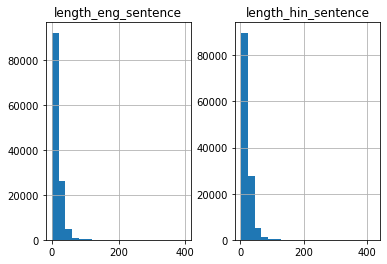

In [14]:
import matplotlib.pyplot as plt

lines[['length_eng_sentence', 'length_hin_sentence']].hist(bins = 20)
plt.show()


In [15]:
# Check how much % of english text have 0-15 words
cnt=0
for i in lines['length_eng_sentence']:
    if i<=50:
        cnt=cnt+1
print(cnt/len(lines['length_eng_sentence']))

0.9759907712273787


In [16]:
# Check how much % of hindi text have 0-20 words
cnt=0
for i in lines['length_eng_sentence']:
    if i<=50:
        cnt=cnt+1
print(cnt/len(lines['length_eng_sentence']))


0.9759907712273787


In [17]:
# Model to translate the text between 0-15 words for english and 0-20 words for hindi
max_length_src=50
max_length_tar=50

In [18]:
# filter out lines with max words as above
lines=lines[lines['length_eng_sentence']<=max_length_src]
lines=lines[lines['length_hin_sentence']<=max_length_tar]
lines.shape

(119658, 5)

In [19]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True,
                                                    random_state=42)
X_train.shape, X_val.shape

((95726,), (23932,))

In [20]:
# Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

# prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

In [21]:
# minimum frequency for common word category
thresh=4

rare_word_cnt=0
tot_cnt=0
rare_word_freq=0
tot_freq=0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        rare_word_cnt = rare_word_cnt+1
        rare_word_freq = rare_word_freq+value
    
print("% of rare words in vocabulary:",(rare_word_cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(rare_word_freq/tot_freq)*100)

% of rare words in vocabulary: 71.9088972107438
Total Coverage of rare words: 4.641379788530157


In [22]:
# prepare a tokenizer as per above count on training data
x_tokenizer = Tokenizer(num_words = tot_cnt)#tot_cnt-rare_word_cnt) 
x_tokenizer.fit_on_texts(list(X_train))

# convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(X_train) 
x_val_seq   =   x_tokenizer.texts_to_sequences(X_val)

# padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_length_src, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_length_src, padding='post')

# size of vocabulary ( +1 for padding token as it is not present in tokenizer vocab)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 61953


In [23]:
# prepare a tokenizer on training data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_train))

# minimum frequency for common word category
thresh=4

rare_word_cnt=0
tot_cnt=0
rare_word_freq=0
tot_freq=0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        rare_word_cnt = rare_word_cnt+1
        rare_word_freq = rare_word_freq+value
    
print("% of rare words in vocabulary:",(rare_word_cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(rare_word_freq/tot_freq)*100)

% of rare words in vocabulary: 67.78627065589285
Total Coverage of rare words: 4.051320133118982


In [24]:
# prepare a tokenizer as per above count on training data
y_tokenizer = Tokenizer(num_words = tot_cnt)#tot_cnt-rare_word_cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# convert text sequences into integer sequences (i.e one-hot encodeing all the words)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq,  maxlen=max_length_tar, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_length_tar, padding='post')

# size of vocabulary ( +1 for padding token as it is not present in tokenizer vocab)
y_voc   =  y_tokenizer.num_words + 1

In [25]:
print("Size of vocabulary in X = {}".format(y_voc))

Size of vocabulary in X = 68686


In [26]:
# Encoder
embedding_dim = 300
latent_dim = 300

encoder_inputs = Input(shape=(max_length_src,))

# Embedding Layer
enc_emb =  Embedding(x_voc, embedding_dim)(encoder_inputs)

# LSTM layer
#encoder_lstm = CuDNNLSTM(latent_dim, return_state=True)
encoder_lstm = LSTM(latent_dim, return_state=True, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard 'encoder_outputs' and only keep the states.
encoder_states = [state_h, state_c]

2022-09-12 20:53:34.605752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 20:53:34.745612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 20:53:34.746390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 20:53:34.747838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
# Set up the decoder, using 'encoder_states' as initial input.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
#decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# 'encoder_input_data' & 'decoder_input_data' into 'decoder_target_data'
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# compile the model
# using sparse categorical crossentropy as we are using time distributed output
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      18585900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    20605800    input_2[0][0]                    
______________________________________________________________________________________________

In [29]:
train_samples = len(x_tr)
val_samples = len(x_val)
batch_size = 128
epochs = 15

In [30]:
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], 
                  batch_size=batch_size,
                  #steps_per_epoch = train_samples//batch_size,
                  epochs=epochs,
                  validation_data = ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
                  #validation_steps = val_samples//batch_size
                   )

2022-09-12 20:53:38.039644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
748/748 [==============================] - 503s 666ms/step - loss: 2.3317 - val_loss: 1.9903
Epoch 2/15
748/748 [==============================] - 501s 670ms/step - loss: 2.0053 - val_loss: 1.8578
Epoch 3/15
748/748 [==============================] - 500s 669ms/step - loss: 1.8789 - val_loss: 1.7703
Epoch 4/15
748/748 [==============================] - 503s 672ms/step - loss: 1.7847 - val_loss: 1.7078
Epoch 5/15
748/748 [==============================] - 502s 671ms/step - loss: 1.7094 - val_loss: 1.6623
Epoch 6/15
748/748 [==============================] - 503s 673ms/step - loss: 1.6486 - val_loss: 1.6317
Epoch 7/15
748/748 [==============================] - 502s 671ms/step - loss: 1.5964 - val_loss: 1.6045
Epoch 8/15
748/748 [==============================] - 504s 673ms/step - loss: 1.5481 - val_loss: 1.5822
Epoch 9/15
748/748 [==============================] - 504s 673ms/step - loss: 1.5050 - val_loss: 1.5682
Epoch 10/15
748/748 [==============================] - 505s 675m

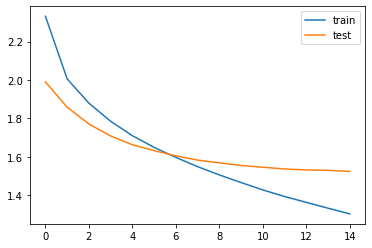

In [31]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
#Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [33]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [34]:
# Encode the input sequence to get the feature vector
# encoder model input and out are taken directly from model defined earlier
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, 
# set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [35]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    20605800    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300)]        0                                            
____________________________________________________________________________________________

In [36]:
#We are defining a function below which is the implementation of the inference process

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='stop'):
            decoded_sentence += ' '+sampled_token
            
        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'stop' or len(decoded_sentence.split()) >= (max_length_tar-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        e_h, e_c = [h, c]

    return decoded_sentence

In [38]:
#Let us define the functions to convert an integer sequence to a word sequence for input

In [39]:
def eng2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

def hindi2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

In [40]:
for i in range(0,10):
    print("English Sentence: ",eng2text(x_tr[i]))
    print('Actual Hindi Translation:', hindi2text(y_tr[i]))
    print("Machine Hindi Translation: ",decode_sequence(x_tr[i].reshape(1,max_length_src)))
    print("\n")

English Sentence:  contrary to widelyheld belief subhas got the impression that tagore was not fundamentally opposed to the concept of noncooperation but had important reservations 
Actual Hindi Translation: start उनसे बातचीत के बाद सुभाष ने महसूस किया कि आम धारणा के विपरीत कवींद्र मूलतया असहयोग के विरोधी नहीं हैं पर उनकी एक महत्वपूर्ण सलाह थी stop 
Machine Hindi Translation:   सुभाष चन्द्र को यह भी था कि उन्होंने अपने को विशेष रूप से लिया था लेकिन वे महात्मा गांधी के सामने नहीं बल्कि यह भी कि एक महत्वपूर्ण बात नहीं थी


English Sentence:  this is inside out 
Actual Hindi Translation: start इसे मैं अन्दर से बाहर उलटना inside out कहता हूँ। stop 
Machine Hindi Translation:   यह है कि


English Sentence:  we identify with all that is in the world 
Actual Hindi Translation: start आप पूरे संसार को अपना परिवार मानने लगते है stop 
Machine Hindi Translation:   हम दुनिया को देख रहे हैं वो सब से जानते हैं


English Sentence:  the brain stem is the nerve tissue that makes up the lowest part of th

In [41]:
input_text =  'he is living with his wife'
ip_seq = x_tokenizer.texts_to_sequences([input_text])
ip_pad = pad_sequences(ip_seq,  maxlen=max_length_src, padding='post')
print("English Sentence: ", input_text)
print("Machine hindi Translation: ", decode_sequence(ip_pad[0].reshape(1,max_length_src)))

English Sentence:  he is living with his wife
Machine hindi Translation:   उसके पास उनके पास ही है
